# Kathmandu Youth Fashion Forecaster — EDA & Starter Notebook

This notebook helps you explore the synthetic 1-year datasets (sales, social, Google Trends), clean and filter to the cohort (Kathmandu, male, ages ~17–25), visualize seasonality, extract hashtags, merge trends, and run a quick Prophet demo for one category.

Place this notebook in your project root `MENS_FASHION_FORECAST/notebooks/` so the `data/` folder is at the same level.

In [1]:
# 0. Setup - run once
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Python executable:", sys.executable)
print("Working dir:", os.getcwd())
print("\nFiles in data/:")
for f in sorted(os.listdir("../data") if os.path.exists("../data") else os.listdir("data")):
    print("-", f)


Python executable: c:\Users\shahi\Desktop\Final Year plan\Mens_Fashion_Forecast\venv\Scripts\python.exe
Working dir: c:\Users\shahi\Desktop\Final Year plan\Mens_Fashion_Forecast\notebooks

Files in data/:
- .gitignore
- google_trends_1yr_nepal.csv
- sales_data_1yr_nepal.csv
- social_media_1yr_nepal.csv


In [2]:
# 1. Load datasets
DATA_DIR = "../data" if os.path.exists("../data") else "data"

sales_fp = os.path.join(DATA_DIR, "sales_data_1yr_nepal.csv")
social_fp = os.path.join(DATA_DIR, "social_media_1yr_nepal.csv")
trends_fp = os.path.join(DATA_DIR, "google_trends_1yr_nepal.csv")

sales = pd.read_csv(sales_fp, parse_dates=["Date"])
social = pd.read_csv(social_fp, parse_dates=["PostDate"])
trends = pd.read_csv(trends_fp, parse_dates=["Date"])

print("sales:", sales.shape)
print("social:", social.shape)
print("trends:", trends.shape)

display(sales.head())
display(social.head())
display(trends.head())

sales: (28346, 9)
social: (31279, 9)
trends: (2190, 4)


,Date,ItemID,City,AgeGroup,Gender,Category,StylePersona,PriceTier,UnitsSold
0,2024-11-01,10000,Kathmandu,15-19,Male,Jackets,K-Fashion Enthusiast,Low,0
1,2024-11-01,10001,Kathmandu,25-30,Female,T-Shirts,Bohemian/Indie,Mid,1
2,2024-11-01,10002,Kathmandu,25-30,Female,Jackets,K-Fashion Enthusiast,Low,0
3,2024-11-01,10003,Kathmandu,25-30,Male,Crop Tops,Bohemian/Indie,Premium,3
4,2024-11-01,10004,Kathmandu,20-24,Male,T-Shirts,American Streetwear,Low,0


,PostDate,PostID,City,AgeGroup,Gender,Caption,Hashtags,StylePersona,Likes
0,2024-11-01,200000,Kathmandu,31-40,Female,Street check in Kathmandu — #indievibes #handmade,#indievibes #handmade,Bohemian/Indie,24
1,2024-11-01,200001,Pokhara,15-19,Female,Layering today: hoodie + jacket. #kpop #seoulv...,#kpop #seoulvibes,K-Fashion Enthusiast,27
2,2024-11-01,200002,Kathmandu,15-19,Male,Thrift finds this weekend. #kstyle,#kstyle,K-Fashion Enthusiast,27
3,2024-11-01,200003,Kathmandu,20-24,Male,New drop in Kathmandu! #seoulvibes #kstyle,#seoulvibes #kstyle,K-Fashion Enthusiast,29
4,2024-11-01,200004,Kathmandu,31-40,Female,Layering today: hoodie + jacket. #seoulvibes #...,#seoulvibes #kpop,K-Fashion Enthusiast,28


,Date,Region,Keyword,InterestScore
0,2024-11-01,Nepal,Hoodies,49
1,2024-11-01,Nepal,Cargo Pants,15
2,2024-11-01,Nepal,Graphic Tees,18
3,2024-11-01,Nepal,Jackets,17
4,2024-11-01,Nepal,Crop Tops,10


In [3]:
# 2. Quick checks
print("Sales columns:", sales.columns.tolist())
print("\nMissing per column (sales):")
print(sales.isnull().sum())
print("\nMissing per column (social):")
print(social.isnull().sum())
print("\nMissing per column (trends):")
print(trends.isnull().sum())

Sales columns: ['Date', 'ItemID', 'City', 'AgeGroup', 'Gender', 'Category', 'StylePersona', 'PriceTier', 'UnitsSold']

Missing per column (sales):
Date            0
ItemID          0
City            0
AgeGroup        0
Gender          0
Category        0
StylePersona    0
PriceTier       0
UnitsSold       0
dtype: int64

Missing per column (social):
PostDate        0
PostID          0
City            0
AgeGroup        0
Gender          0
Caption         0
Hashtags        0
StylePersona    0
Likes           0
dtype: int64

Missing per column (trends):
Date             0
Region           0
Keyword          0
InterestScore    0
dtype: int64


In [ ]:
### 🧠 Step 5 – Exploring Daily and Category-wise Sales Trends

In this step, we visualize **sales activity over time** to understand how clothing demand changes across the year.

We’ll create two key visualizations:

1. **Total Daily Units Sold (7-day Moving Average)**  
   - Groups all categories by date and plots the total daily units sold.  
   - The **7-day moving average (7d MA)** smooths out random fluctuations (like weekend spikes) and highlights overall trends.  
   - This helps reveal broad **seasonal patterns** — for example, higher sales in winter (jackets, hoodies) and dips during summer.

2. **Category-wise 7-day Rolling Average**  
   - Groups data by both *Date* and *Category* to track each clothing type (T-shirts, Jackets, Pants, Hoodies).  
   - The 7-day rolling average for each category shows **which styles are trending during specific months**.  
   - For instance, “Hoodies” may peak during colder months, while “T-shirts” might rise in warmer seasons.

By smoothing the daily sales, we can see **clearer, long-term fashion demand patterns**, which are essential before building any AI forecasting model.

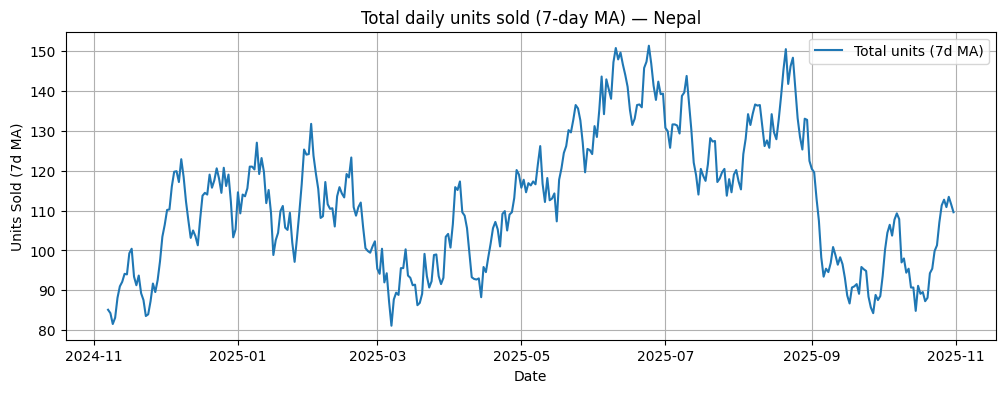

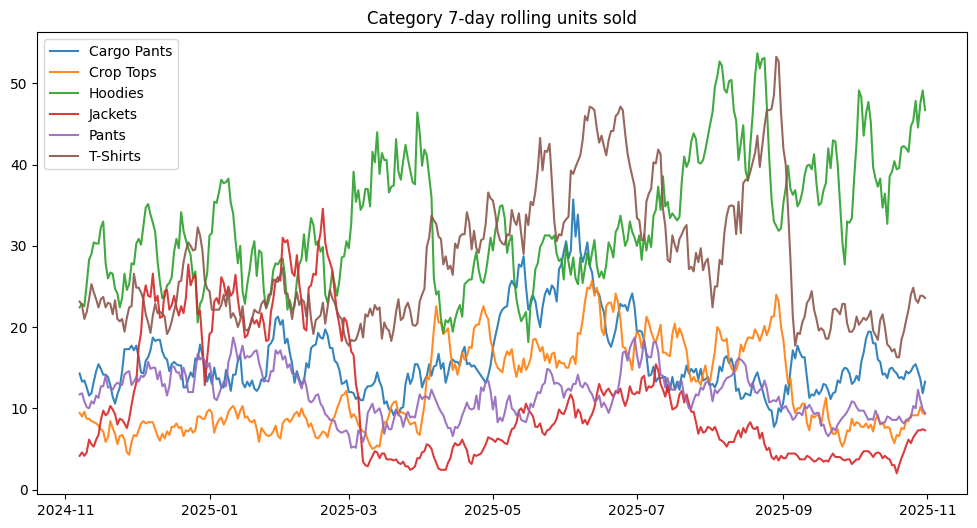

In [4]:
# 3. Aggregate overview: total daily sales and category series
daily_total = sales.groupby("Date")["UnitsSold"].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily_total["Date"], daily_total["UnitsSold"].rolling(7).mean(), label="Total units (7d MA)")
plt.title("Total daily units sold (7-day MA) — Nepal")
plt.xlabel("Date"); plt.ylabel("Units Sold (7d MA)")
plt.grid(True); plt.legend()
plt.show()

# Category series (7-day rolling)
cat_ts = sales.groupby(["Date","Category"])["UnitsSold"].sum().unstack(fill_value=0)
cat_ts_7 = cat_ts.rolling(7).mean()
plt.figure(figsize=(12,6))
for c in cat_ts_7.columns:
    plt.plot(cat_ts_7.index, cat_ts_7[c], label=c, alpha=0.9)
plt.legend(); plt.title("Category 7-day rolling units sold")
plt.show()

### 🎯 Step 4 – Filtering Data for the Target Cohort (Urban Male, Age 17–25, Kathmandu)

Our project specifically focuses on **predicting clothing trends and optimizing inventory** for **urban males aged 17–25 in Kathmandu**.  
To make our analysis relevant to this audience, we need to isolate this demographic from the overall dataset.

Here’s what this step does:
1. **Select age groups “15–19” and “20–24”**  
   → These two brackets approximate our 17–25 target age range.
2. **Filter by Gender = Male**  
   → Focus only on male consumer behavior.
3. **Filter by City = Kathmandu**  
   → Our geographic scope is the urban market of Nepal’s capital, where youth fashion trends are most dynamic.
4. **Create two filtered datasets:**
   - `sales_cohort` → only relevant sales transactions.
   - `social_cohort` → only relevant social media activity.

Finally, we display:
- The number of filtered rows in each dataset (for sanity checking).
- The top-selling fashion categories for this group (using a grouped summary).

📊 **Why it matters:**  
This filtering ensures that all further analysis — trend detection, correlation with Google Trends, and AI forecasting — is based purely on the **intended customer segment**, rather than the general population.  
It’s the foundation for an accurate, personalized forecasting model tailored to **Kathmandu’s male youth fashion market**.

In [11]:
# 4. Filter to your cohort: Kathmandu, Male, ages 15-19 & 20-24 (approx 17-25)
cohort_ages = ["15-19","20-24"]
sales_cohort = sales[
    (sales["City"] == "Kathmandu") &
    (sales["Gender"] == "Male") &
    (sales["AgeGroup"].isin(cohort_ages))
].copy()
social_cohort = social[
    (social["City"] == "Kathmandu") &
    (social["Gender"] == "Male") &
    (social["AgeGroup"].isin(cohort_ages))
].copy()

print("sales_cohort rows:", len(sales_cohort))
print("social_cohort rows:", len(social_cohort))
display(sales_cohort.groupby("Category")["UnitsSold"].sum().sort_values(ascending=False).reset_index().head(10))


sales_cohort rows: 3437
social_cohort rows: 6584


,Category,UnitsSold
0,Hoodies,2328
1,T-Shirts,1863
2,Cargo Pants,1086
3,Crop Tops,883
4,Pants,780
5,Jackets,660


### 🧩 Step 5 – Hashtag Analysis: Understanding Fashion Identity and Social Trends

In this step, we analyze **social media hashtags** used by our target audience — *urban males aged 17–25 in Kathmandu*.  
Hashtags are a strong indicator of **fashion identity**, **style affiliation**, and **emerging micro-trends** among youth communities.

#### 🔍 What this cell does:
1. **Extract hashtags from captions**
   - A helper function `extract_hashtags()` cleans and normalizes the text.
   - It removes commas, splits text, and extracts tokens starting with `#`.
   - Hashtags are converted to lowercase to avoid duplicates (e.g., `#Streetwear` = `#streetwear`).

2. **Aggregate and visualize the most common hashtags**
   - We count all hashtags across posts in `social_cohort`.
   - The top 25 hashtags are plotted in a bar chart.
   - This shows which *fashion conversations and subcultures* are most active (e.g., `#streetstyle`, `#hoodies`, `#minimal`).

3. **Display the most liked posts**
   - The table of top 8 posts (sorted by likes) helps identify *influential trends* and *aesthetic patterns* resonating with this demographic.

#### 💡 Why this matters:
- Hashtags represent **psychological expression** — people signal their identity, group belonging, and taste via fashion-related tags.  
- By analyzing them, we can detect *style tribes* (like streetwear, minimalist, or K-fashion followers).  
- These insights complement quantitative sales data and help our AI model understand **how fashion psychology influences purchasing trends**.

This step bridges **social identity cues** (hashtags, likes) with **market data** (sales and Google Trends), forming the behavioral foundation for forecasting.

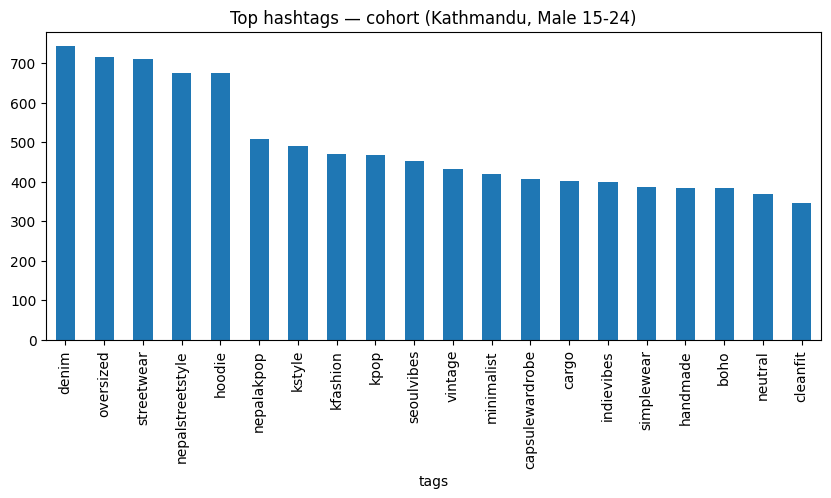

,PostDate,Caption,Hashtags,Likes
22143,2025-07-20,New drop in Kathmandu! #vintage,#vintage,51
25790,2025-08-31,Thrift finds this weekend. #capsulewardrobe,#capsulewardrobe,50
25101,2025-08-24,Street check in Kathmandu — #oversized,#oversized,48
24328,2025-08-15,Minimal fit for the office. #minimalist,#minimalist,48
1247,2024-11-16,Thrift finds this weekend. #denim,#denim,47
4864,2024-12-26,Minimal fit for the office. #cleanfit,#cleanfit,46
6542,2025-01-12,New drop in Kathmandu! #nepalakpop,#nepalakpop,45
8091,2025-02-01,Layering today: hoodie + jacket. #boho #indiev...,#boho #indievibes,45


In [6]:
# 5. Hashtag analysis (normalize and count)
def extract_hashtags(s):
    if pd.isna(s): 
        return []
    # replace commas with spaces then split
    parts = [p.strip() for p in s.replace(",", " ").split()]
    tags = [p.lstrip("#").lower() for p in parts if p.startswith("#") or p.startswith(" #") or len(p)>0]
    # filter tokens that look like tags (start with # or alpha)
    tags = [t for t in tags if len(t)>0]
    return tags

social_cohort["tags"] = social_cohort["Hashtags"].apply(extract_hashtags)
all_tags = social_cohort["tags"].explode().dropna()
top_tags = all_tags.value_counts().head(25)
plt.figure(figsize=(10,4))
top_tags.plot.bar()
plt.title("Top hashtags — cohort (Kathmandu, Male 15-24)")
plt.show()

# Show sample top posts
display(social_cohort.sort_values("Likes", ascending=False)[["PostDate","Caption","Hashtags","Likes"]].head(8))


### 📊 Step 6 – Merging Google Trends with Sales for a Category (Example: Hoodies)

In this step, we examine the relationship between **online search interest** and **actual sales** for a specific category — here, “Hoodies” — among our target cohort (urban males aged 17–25 in Kathmandu).

#### 🔍 What this cell does:

1. **Filter and aggregate sales data**
   - Select only sales for the category `Hoodies` from `sales_cohort`.
   - Group by `Date` and sum `UnitsSold`.
   - Use `.asfreq("D")` to ensure a **daily time series**, filling any missing days with 0.

2. **Filter and aggregate Google Trends data**
   - Select rows in `trends` where `Keyword` matches `Hoodies`.
   - Group by `Date` and take the mean `InterestScore`.
   - Fill missing days using forward fill (`ffill`) to maintain continuity.

3. **Merge sales and trends**
   - Combine both datasets on `Date`.
   - Fill any remaining missing `InterestScore` with 0.

4. **Visualize**
   - Plot **UnitsSold** (7-day moving average) on the left y-axis.
   - Plot **Google Trends InterestScore** on the right y-axis.
   - This side-by-side comparison allows us to **see if spikes in search interest precede or coincide with sales trends**.

#### 💡 Why this matters:

- Google Trends represents **digital consumer intent**, while `UnitsSold` represents **actual purchasing behavior**.
- By analyzing their alignment, we can:
  - Identify **leading indicators** for demand.
  - Validate that **online interest correlates with retail sales**.
  - Strengthen the foundation for **AI forecasting models** that incorporate external signals.
- This step demonstrates how **digital trends can inform inventory decisions**, helping retailers

C:\Users\shahi\AppData\Local\Temp\ipykernel_10440\3355584834.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  trend_cat = trends[trends["Keyword"].str.lower() == cat.lower()].groupby("Date")["InterestScore"].mean().reset_index().set_index("Date").asfreq("D").fillna(method="ffill").reset_index()
C:\Users\shahi\AppData\Local\Temp\ipykernel_10440\3355584834.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged["InterestScore"] = merged["InterestScore"].fillna(method="ffill").fillna(0)


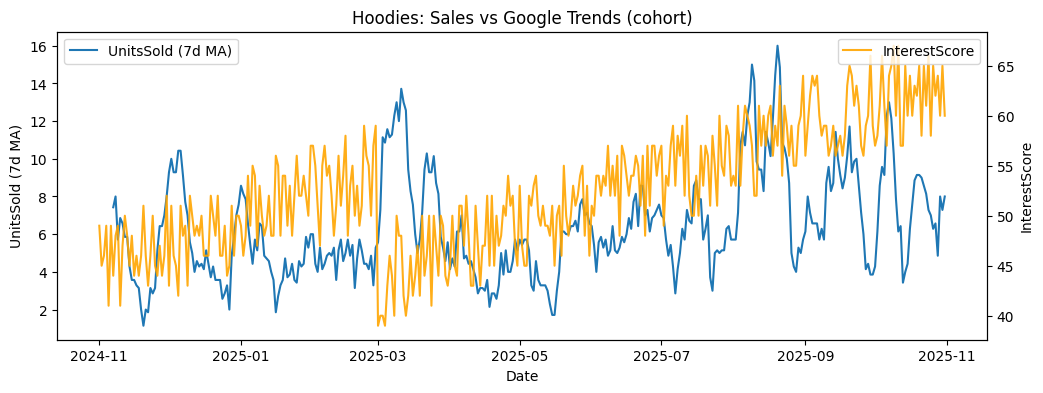

In [12]:
# 6. Merge Google Trends with sales for a category (example: Hoodies)
cat = "Hoodies"
sales_cat = sales_cohort[sales_cohort["Category"]==cat].groupby("Date")["UnitsSold"].sum().reset_index().set_index("Date").asfreq("D").fillna(0).reset_index()
trend_cat = trends[trends["Keyword"].str.lower() == cat.lower()].groupby("Date")["InterestScore"].mean().reset_index().set_index("Date").asfreq("D").fillna(method="ffill").reset_index()
merged = sales_cat.merge(trend_cat, on="Date", how="left")
merged["InterestScore"] = merged["InterestScore"].fillna(method="ffill").fillna(0)

# Plot side-by-side with secondary y-axis
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(merged["Date"], merged["UnitsSold"].rolling(7).mean(), label="UnitsSold (7d MA)")
ax1.set_xlabel("Date"); ax1.set_ylabel("UnitsSold (7d MA)")
ax2 = ax1.twinx()
ax2.plot(merged["Date"], merged["InterestScore"], color="orange", label="InterestScore", alpha=0.9)
ax2.set_ylabel("InterestScore")
ax1.legend(loc="upper left"); ax2.legend(loc="upper right")
plt.title(f"{cat}: Sales vs Google Trends (cohort)")
plt.show()


### 🤖 Step 7 – Forecasting Sales with Prophet Including Google Trends as Regressor

In this step, we build a **time-series forecasting model** using **Prophet** to predict future sales for the category “Hoodies” among our target cohort.

#### 🔍 What this cell does:

1. **Prepare the data for Prophet**
   - Prophet requires a DataFrame with columns:
     - `ds` → date
     - `y` → value to predict (UnitsSold)
   - We also include `InterestScore` from Google Trends as an **external regressor** to help the model capture the influence of online search interest on sales.

2. **Split into training and future sets**
   - `train` → all data except the last 30 days (used for evaluation).
   - `future` → next 30 days for prediction.
   - Missing `InterestScore` values are forward-filled to maintain continuity.

3. **Configure Prophet model**
   - `weekly_seasonality=True` → captures weekly sales cycles (e.g., weekend spikes in shopping).
   - `yearly_seasonality=False` → optional if only analyzing <1 year of data.
   - Add `InterestScore` as an **extra regressor** to incorporate online search behavior into predictions.

4. **Fit the model and make predictions**
   - The model learns from historical sales patterns and the trend in Google search interest.
   - Forecast includes:
     - `yhat` → predicted sales
     - `yhat_lower` and `yhat_upper` → uncertainty bounds

5. **Visualize results**
   - The plot shows predicted sales with confidence intervals, helping retailers anticipate demand for the next month.

#### 💡 Why this matters:

- Including Google Trends as a regressor links **digital consumer intent** to **physical sales**, enhancing predictive accuracy.
- Prophet captures **temporal patterns** (weekly seasonality, short-term trends) automatically.
- The forecast provides actionable insights for **inventory planning**, allowing retailers to proactively adjust stock for the 17–25 male demographic in Kathmandu.

,ds,y,InterestScore
0,2024-11-01,2.0,49.0
1,2024-11-02,16.0,45.0
2,2024-11-03,0.0,46.0
3,2024-11-04,3.0,49.0
4,2024-11-05,14.0,41.0


20:00:45 - cmdstanpy - INFO - Chain [1] start processing
20:00:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\shahi\AppData\Local\Temp\ipykernel_10440\2354237739.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future["InterestScore"] = future["InterestScore"].fillna(method="ffill").fillna(0)


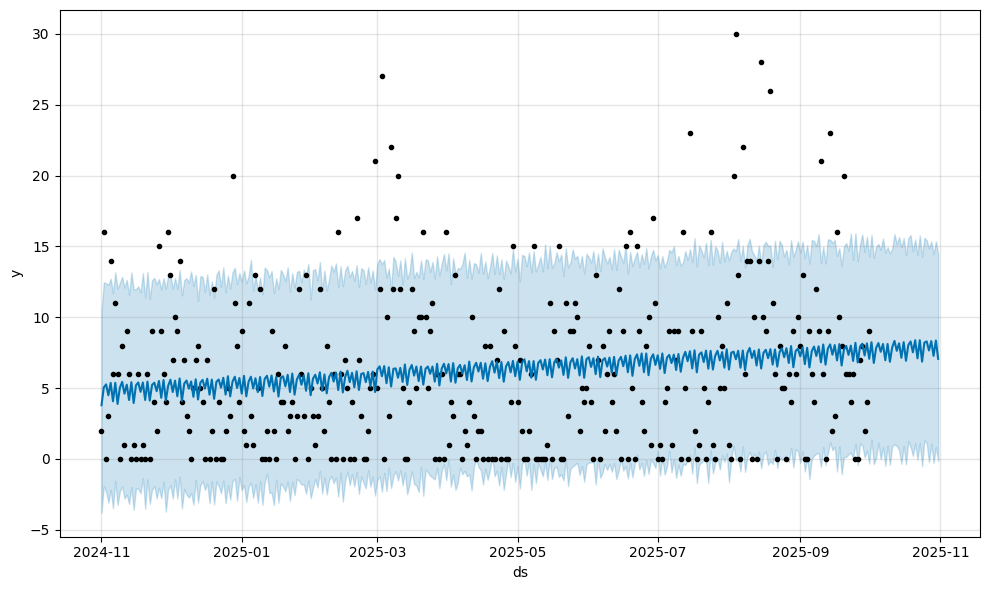

,ds,yhat,yhat_lower,yhat_upper
355,2025-10-22,7.103341,-0.046370,14.412722
356,2025-10-23,8.380733,1.121429,15.778254
357,2025-10-24,6.871627,-0.518520,14.260286
358,2025-10-25,8.210443,1.320545,15.598618
359,2025-10-26,8.299047,1.123515,15.445112
360,2025-10-27,7.659630,-0.223040,14.845979
361,2025-10-28,8.319382,1.076209,15.361210
362,2025-10-29,7.278238,-0.280846,14.452658
363,2025-10-30,8.362586,0.831672,15.365347
364,2025-10-31,7.067973,-0.140750,14.499060


In [13]:
# 7. Prepare df for Prophet (ds,y) and include InterestScore as regressor
from prophet import Prophet

df = merged.rename(columns={"Date":"ds","UnitsSold":"y"})[["ds","y","InterestScore"]].sort_values("ds").reset_index(drop=True)
display(df.head())

# Fit Prophet on train (all but last 30 days)
train = df.iloc[:-30]
m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=False)
m.add_regressor("InterestScore")
m.fit(train)

# Make future (30 days) and fill regressor
future = m.make_future_dataframe(periods=30)
future = future.merge(df[["ds","InterestScore"]], on="ds", how="left")
future["InterestScore"] = future["InterestScore"].fillna(method="ffill").fillna(0)

forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

display(forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10))


### 📦 Step 8 – Translating Forecast into Simple Inventory Recommendations

Once we have predicted sales from Prophet, we can turn these forecasts into **actionable inventory decisions** for retailers.

#### 🔍 What this cell does:

1. **Compute predicted means**
   - `recent_mean` → average predicted sales for the **next 30 days**.
   - `prev_mean` → average predicted sales for the **previous 30 days** (used as a baseline).

2. **Apply simple inventory rules**
   - If the recent forecast is **>20% higher** than the previous period → **Increase stock**  
     🔺 Strong predicted demand rise.
   - If the recent forecast is **<85%** of the previous period → **Consider markdowns or reduce ordering**  
     🔻 Predicted decline in demand.
   - Otherwise → **Hold current inventory**  
     ⚖️ Stable forecast; no major change needed.

3. **Print recommendation**
   - Provides a **clear, actionable message** for retail managers.

#### 💡 Why this matters:

- This step demonstrates how **AI-driven forecasts** can directly inform **inventory management decisions**, reducing overstock or stockouts.
- The simple rule-based approach is easy to interpret and communicate.
- For your project, these recommendations are specifically tailored for **urban males aged 17–25 in Kathmandu**, linking forecasted demand with operational decisions.


In [14]:
# 8. Simple inventory rule example
recent_mean = forecast.tail(30)["yhat"].mean()
prev_mean = forecast.iloc[-60:-30]["yhat"].mean()
print("Recent mean (predicted):", round(recent_mean,2))
print("Previous mean (predicted):", round(prev_mean,2))
if recent_mean > prev_mean * 1.2:
    print("Recommendation: 🔺 Increase stock (predicted strong rise).")
elif recent_mean < prev_mean * 0.85:
    print("Recommendation: 🔻 Consider markdowns/less ordering (predicted decline).")
else:
    print("Recommendation: ⚖️ Hold current inventory (stable forecast).")

Recent mean (predicted): 7.76
Previous mean (predicted): 7.52
Recommendation: ⚖️ Hold current inventory (stable forecast).


In [15]:
# 9. Save sample merged and forecast files for the app or later use
out_dir = os.path.join(DATA_DIR if 'DATA_DIR' in globals() else "../data")
merged.to_csv(os.path.join(out_dir, f"preview_merged_{cat.lower().replace(' ','_')}.csv"), index=False)
forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv(os.path.join(out_dir, f"preview_forecast_{cat.lower().replace(' ','_')}.csv"), index=False)
print("Saved preview files to:", out_dir)

Saved preview files to: ../data


## Next steps & notes

- Repeat the Prophet demo for other categories (copy cells 8–10, change `cat`).
- Run `src/02_feature_engineer.py` to create full `data/features/feat_<category>.csv` files for model training (XGBoost).
- Run `src/03_train_models.py` to train models across categories and save models to `models/`.
- When models exist, run `streamlit run app/app.py` to view the interactive dashboard.